In [1]:
import pandas as pd
import numpy as np

PATH = "../data/transformado/quejas_limpias.csv"
df = pd.read_csv(PATH)
df.head()


,Product,Sub_product,Issue,Sub_issue,State,ZIP_code,Date_received,Date_sent_to_company,Company,Company_response,Timely_response,Consumer_disputed,target_disputed,Days_to_response
0,4,Desconocido,Communication tactics,Frequent or repeated calls,51,76119.0,2015-03-19,2015-03-19,1069,4,1,0,0,0
1,4,Medical,Cont'd attempts collect debt not owed,Debt is not mine,51,77479.0,2015-03-19,2015-03-19,50,1,1,0,0,0
2,6,FHA mortgage,"Application, originator, mortgage broker",Desconocido,24,2127.0,2015-03-19,2015-03-19,1118,1,1,1,1,0
3,2,Desconocido,Other,Desconocido,7,92592.0,2015-03-19,2015-03-19,967,4,1,0,0,0
4,4,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,12,43068.0,2015-03-19,2015-03-19,1401,4,1,0,0,0


In [2]:
date_cols = [c for c in ["Date_received","Date_sent_to_company"] if c in df.columns]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28156 entries, 0 to 28155
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Product               28156 non-null  int64         
 1   Sub_product           28156 non-null  object        
 2   Issue                 28156 non-null  object        
 3   Sub_issue             28156 non-null  object        
 4   State                 28156 non-null  int64         
 5   ZIP_code              28156 non-null  object        
 6   Date_received         28156 non-null  datetime64[ns]
 7   Date_sent_to_company  28156 non-null  datetime64[ns]
 8   Company               28156 non-null  int64         
 9   Company_response      28156 non-null  int64         
 10  Timely_response       28156 non-null  int64         
 11  Consumer_disputed     28156 non-null  int64         
 12  target_disputed       28156 non-null  int64         
 13  Days_to_response

,target_disputed,count,pct
0,0,23449,0.832824
1,1,4707,0.167176


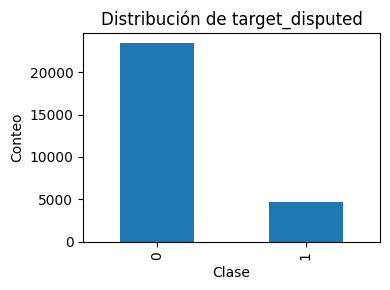

1 0.1672


In [3]:
import matplotlib.pyplot as plt

y = df["target_disputed"].astype(int)
vc = y.value_counts().sort_index()
dist = pd.DataFrame({"target_disputed": vc.index, "count": vc.values})
dist["pct"] = dist["count"] / dist["count"].sum()
display(dist)

plt.figure(figsize=(4,3))
vc.plot(kind="bar")
plt.title("Distribución de target_disputed")
plt.xlabel("Clase")
plt.ylabel("Conteo")
plt.tight_layout()
plt.show()

minority_idx = dist["pct"].idxmin()
minority_class = int(dist.loc[minority_idx, "target_disputed"])
minority_rate = float(dist.loc[minority_idx, "pct"])
print(minority_class, round(minority_rate, 4))


Clase 0 (No disputado): ~22,000 casos.
Clase 1 (Disputado): ~5,000 casos.
Esto significa que aproximadamente 1 de cada 5 quejas (≈18–20%) termina en disputa.
El problema es desbalanceado: la clase positiva (disputas) es minoritaria.

En negocio esto tiene mucho sentido: no todas las quejas escalan a disputa, pero cuando lo hacen generan más coste, riesgo y mala experiencia.

Para el modelado no podemos quedarnos solo con precisión (“acierto total”), porque un modelo que predijera siempre 0 tendría 80% de accuracy pero no detectaría ninguna disputa, lo cual sería inútil.

,total,disputas,pct_disputas
Product,,,
2,2830,557,0.196820
1,1314,232,0.176560
6,6612,1134,0.171506
0,2609,446,0.170947
4,7494,1277,0.170403
9,175,28,0.160000
5,232,37,0.159483
10,785,123,0.156688
8,348,53,0.152299


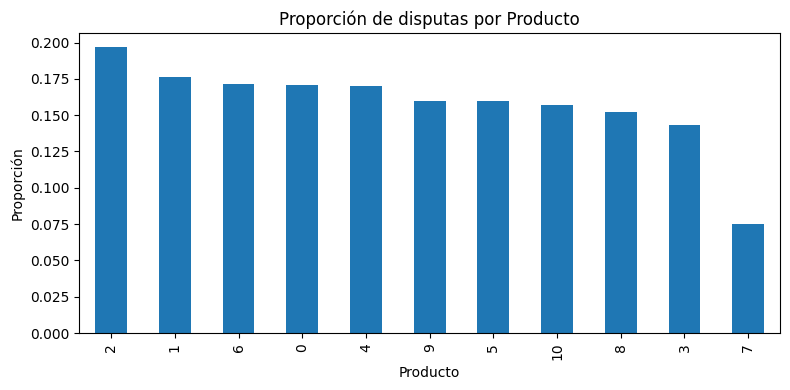

In [4]:
prod_dist = (
    df.groupby("Product")["target_disputed"]
    .agg(["count","sum"])
    .rename(columns={"count":"total","sum":"disputas"})
)
prod_dist["pct_disputas"] = prod_dist["disputas"] / prod_dist["total"]

display(prod_dist.sort_values("pct_disputas", ascending=False).head(10))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
prod_dist.sort_values("pct_disputas", ascending=False)["pct_disputas"].plot(kind="bar")
plt.title("Proporción de disputas por Producto")
plt.ylabel("Proporción")
plt.xlabel("Producto")
plt.tight_layout()
plt.show()


In [5]:
from sklearn.preprocessing import LabelEncoder
raw = pd.read_csv("../data/quejas-clientes.csv", low_memory=False)

le_product = LabelEncoder()
raw_products = raw["Product"].fillna("Desconocido")
le_product.fit(raw_products)

product_mapping = dict(zip(le_product.classes_, le_product.transform(le_product.classes_)))
product_mapping.keys()


dict_keys(['Bank account or service', 'Consumer loan', 'Credit card', 'Credit reporting', 'Debt collection', 'Money transfers', 'Mortgage', 'Other financial service', 'Payday loan', 'Prepaid card', 'Student loan'])

,total,disputas,pct_disputas
Product,,,
Credit card,2830,557,0.196820
Consumer loan,1314,232,0.176560
Mortgage,6612,1134,0.171506
Bank account or service,2609,446,0.170947
Debt collection,7494,1277,0.170403
Prepaid card,175,28,0.160000
Money transfers,232,37,0.159483
Student loan,785,123,0.156688
Payday loan,348,53,0.152299


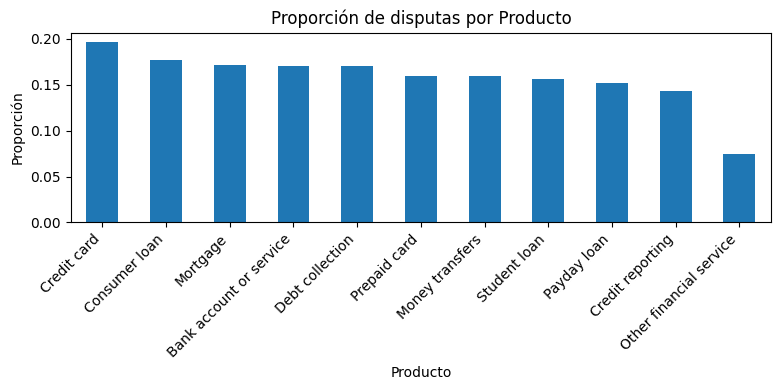

In [6]:
prod_dist = (
    df.groupby("Product")["target_disputed"]
    .agg(["count","sum"])
    .rename(columns={"count":"total","sum":"disputas"})
)
prod_dist["pct_disputas"] = prod_dist["disputas"] / prod_dist["total"]

inv_product_mapping = {v: k for k, v in product_mapping.items()}
prod_dist.index = prod_dist.index.map(inv_product_mapping)

prod_dist = prod_dist.sort_values("pct_disputas", ascending=False)

display(prod_dist)

plt.figure(figsize=(8,4))
prod_dist["pct_disputas"].plot(kind="bar")
plt.title("Proporción de disputas por Producto")
plt.ylabel("Proporción")
plt.xlabel("Producto")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


,total,disputas,pct_disputas
Company,,,
1064,229,64,0.279476
489,396,99,0.250000
1038,112,28,0.250000
1230,133,32,0.240602
1341,217,49,0.225806
195,114,25,0.219298
1261,111,24,0.216216
955,749,160,0.213618
113,270,56,0.207407


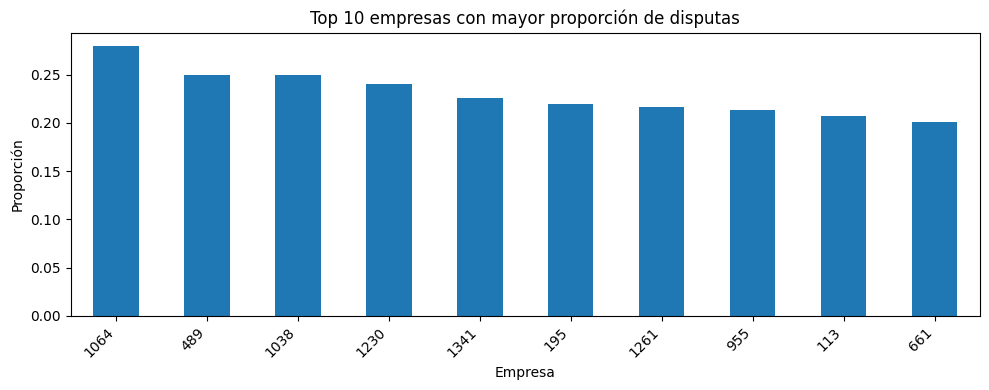

In [7]:
comp_dist = (
    df.groupby("Company")["target_disputed"]
    .agg(["count","sum"])
    .rename(columns={"count":"total","sum":"disputas"})
)
comp_dist["pct_disputas"] = comp_dist["disputas"] / comp_dist["total"]

comp_dist = comp_dist[comp_dist["total"] > 100]  # filtrar empresas con pocas quejas
comp_dist = comp_dist.sort_values("pct_disputas", ascending=False)

display(comp_dist.head(10))

plt.figure(figsize=(10,4))
comp_dist.head(10)["pct_disputas"].plot(kind="bar")
plt.title("Top 10 empresas con mayor proporción de disputas")
plt.ylabel("Proporción")
plt.xlabel("Empresa")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


,total,disputas,pct_disputas
Company_response,,,
1,19381,3985,0.205614
0,606,114,0.188119
3,3593,453,0.126078
2,1534,155,0.101043
4,2690,0,0.000000
5,352,0,0.000000


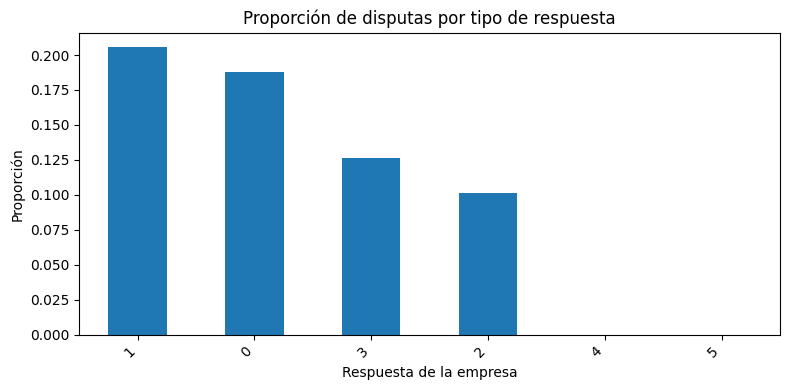

In [8]:
resp_dist = (
    df.groupby("Company_response")["target_disputed"]
    .agg(["count","sum"])
    .rename(columns={"count":"total","sum":"disputas"})
)
resp_dist["pct_disputas"] = resp_dist["disputas"] / resp_dist["total"]

resp_dist = resp_dist.sort_values("pct_disputas", ascending=False)

display(resp_dist)

plt.figure(figsize=(8,4))
resp_dist["pct_disputas"].plot(kind="bar")
plt.title("Proporción de disputas por tipo de respuesta")
plt.ylabel("Proporción")
plt.xlabel("Respuesta de la empresa")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [9]:
raw = pd.read_csv("../data/quejas-clientes.csv", low_memory=False)

from sklearn.preprocessing import LabelEncoder
le_resp = LabelEncoder()

raw_responses = raw["Company response"].fillna("Desconocido")
le_resp.fit(raw_responses)

resp_mapping = dict(zip(le_resp.transform(le_resp.classes_), le_resp.classes_))
resp_mapping


{np.int64(0): 'Closed',
 np.int64(1): 'Closed with explanation',
 np.int64(2): 'Closed with monetary relief',
 np.int64(3): 'Closed with non-monetary relief',
 np.int64(4): 'In progress',
 np.int64(5): 'Untimely response'}

,total,disputas,pct_disputas
Company_response,,,
Closed with explanation,19381,3985,0.205614
Closed,606,114,0.188119
Closed with non-monetary relief,3593,453,0.126078
Closed with monetary relief,1534,155,0.101043
In progress,2690,0,0.000000
Untimely response,352,0,0.000000


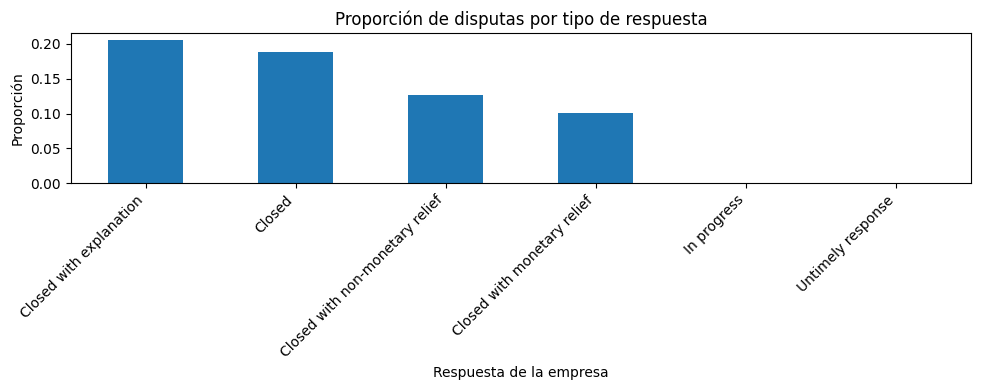

In [10]:
resp_dist_named = resp_dist.copy()
resp_dist_named.index = resp_dist_named.index.map(resp_mapping)

display(resp_dist_named)

plt.figure(figsize=(10,4))
resp_dist_named["pct_disputas"].plot(kind="bar")
plt.title("Proporción de disputas por tipo de respuesta")
plt.ylabel("Proporción")
plt.xlabel("Respuesta de la empresa")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


,total,disputas,pct_disputas
Timely_response,,,
0,712,47,0.066011
1,27444,4660,0.169800


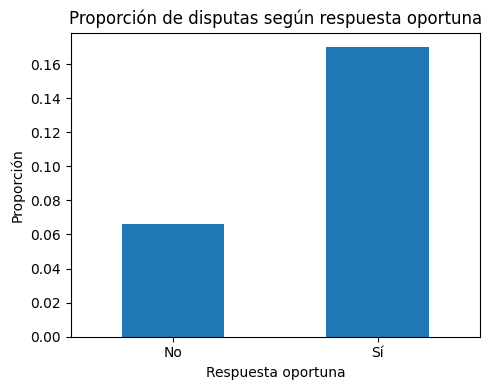

In [11]:
timely_dist = (
    df.groupby("Timely_response")["target_disputed"]
    .agg(["count","sum"])
    .rename(columns={"count":"total","sum":"disputas"})
)
timely_dist["pct_disputas"] = timely_dist["disputas"] / timely_dist["total"]

display(timely_dist)

plt.figure(figsize=(5,4))
timely_dist["pct_disputas"].plot(kind="bar")
plt.title("Proporción de disputas según respuesta oportuna")
plt.ylabel("Proporción")
plt.xlabel("Respuesta oportuna")
plt.xticks([0,1], ["No","Sí"], rotation=0)
plt.tight_layout()
plt.show()


<Figure size 600x400 with 0 Axes>

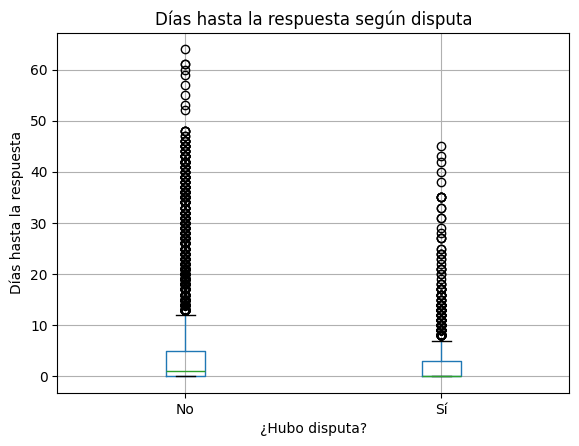

In [12]:
plt.figure(figsize=(6,4))
df.boxplot(column="Days_to_response", by="target_disputed")
plt.title("Días hasta la respuesta según disputa")
plt.suptitle("")
plt.xlabel("¿Hubo disputa?")
plt.ylabel("Días hasta la respuesta")
plt.xticks([1,2], ["No","Sí"])
plt.show()


In [13]:
df.groupby("target_disputed")["Days_to_response"].mean()


target_disputed
0    3.133566
1    2.092416
Name: Days_to_response, dtype: float64

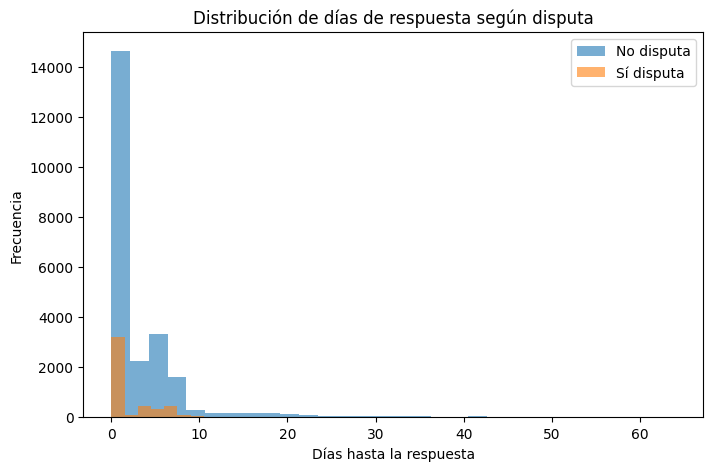

In [14]:
plt.figure(figsize=(8,5))
df[df["target_disputed"]==0]["Days_to_response"].plot(kind="hist", bins=30, alpha=0.6, label="No disputa")
df[df["target_disputed"]==1]["Days_to_response"].plot(kind="hist", bins=30, alpha=0.6, label="Sí disputa")
plt.legend()
plt.title("Distribución de días de respuesta según disputa")
plt.xlabel("Días hasta la respuesta")
plt.ylabel("Frecuencia")
plt.show()


In [15]:
bins = [0,1,3,5,10,30,100]
df["bin_days"] = pd.cut(df["Days_to_response"], bins=bins)

risk_table = df.groupby("bin_days")["target_disputed"].mean().reset_index()
risk_table


C:\Users\QiliDev\AppData\Local\Temp\ipykernel_6872\3933730653.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_table = df.groupby("bin_days")["target_disputed"].mean().reset_index()


,bin_days,target_disputed
0,"(0, 1]",0.179458
1,"(1, 3]",0.158515
2,"(3, 5]",0.160183
3,"(5, 10]",0.136274
4,"(10, 30]",0.081152
5,"(30, 100]",0.053030


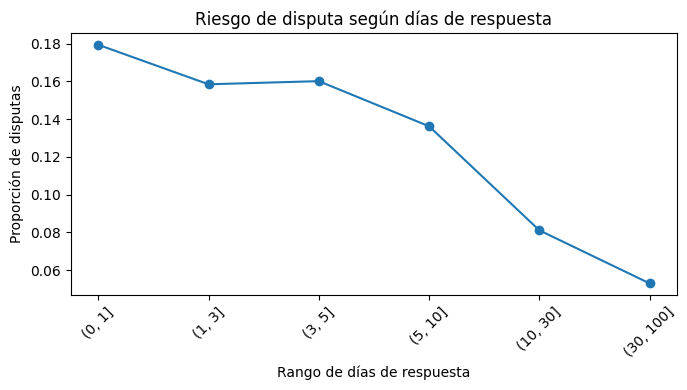

In [16]:
plt.figure(figsize=(7,4))
plt.plot(risk_table["bin_days"].astype(str), risk_table["target_disputed"], marker="o")
plt.title("Riesgo de disputa según días de respuesta")
plt.xlabel("Rango de días de respuesta")
plt.ylabel("Proporción de disputas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
df["Issue_len"] = df["Issue"].fillna("").astype(str).str.len()
df["Sub_issue_words"] = df["Sub_issue"].fillna("").astype(str).str.split().str.len()
df[["Issue_len","Sub_issue_words"]].describe()


,Issue_len,Sub_issue_words
count,28156.000000,28156.000000
mean,33.805121,2.514633
std,8.122232,1.953745
min,4.000000,1.000000
25%,31.000000,1.000000
50%,37.000000,1.000000
75%,40.000000,4.000000
max,40.000000,8.000000


In [18]:
print("Shape:", df.shape)
print("\nTipos de datos:")
print(df.dtypes)

print("\nValores nulos totales:", df.isnull().sum().sum())
print("\nBalance de clases (Consumer_disputed):")
print(df["Consumer_disputed"].value_counts(normalize=True))


Shape: (28156, 17)

Tipos de datos:
Product                          int64
Sub_product                     object
Issue                           object
Sub_issue                       object
State                            int64
ZIP_code                        object
Date_received           datetime64[ns]
Date_sent_to_company    datetime64[ns]
Company                          int64
Company_response                 int64
Timely_response                  int64
Consumer_disputed                int64
target_disputed                  int64
Days_to_response                 int64
bin_days                      category
Issue_len                        int64
Sub_issue_words                  int64
dtype: object

Valores nulos totales: 12987

Balance de clases (Consumer_disputed):
Consumer_disputed
0    0.832824
1    0.167176
Name: proportion, dtype: float64


In [20]:
company_counts = df["Company"].value_counts()
threshold = 100
rare_companies = company_counts[company_counts < threshold].index
df["Company_grouped"] = df["Company"].replace(rare_companies, "Otras")
df["Company_grouped"].value_counts().head(10)


Company_grouped
Otras    9495
494      2049
504      1940
1398     1525
190      1518
1498     1430
729      1272
312      1016
996       934
955       749
Name: count, dtype: int64

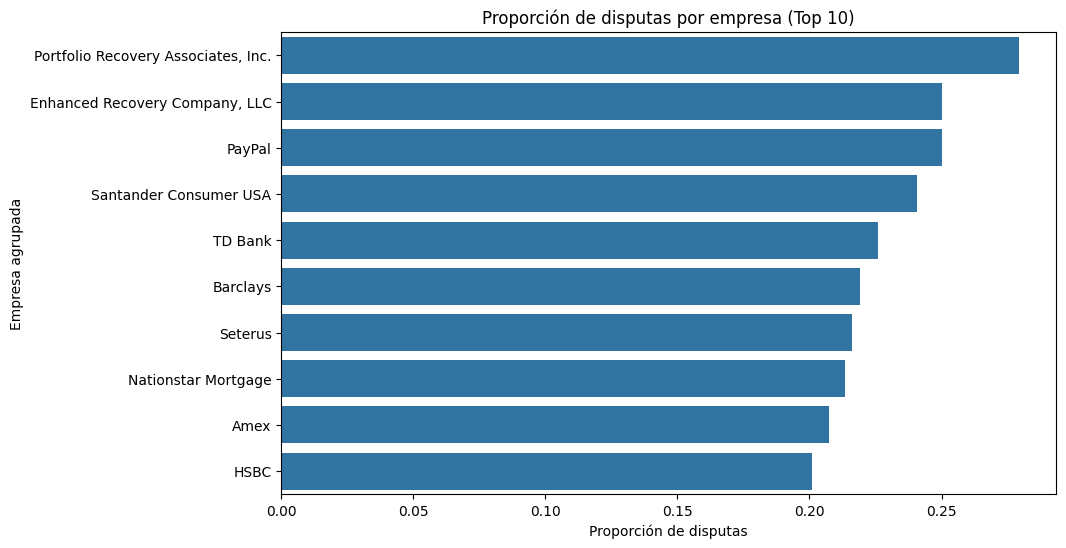

In [24]:
raw = pd.read_csv("../data/quejas-clientes.csv", low_memory=False)

company_counts = raw["Company"].value_counts()
threshold = 100
rare_companies = company_counts[company_counts < threshold].index
raw["Company_grouped"] = raw["Company"].replace(rare_companies, "Otras")

company_disputes = (
    raw.groupby("Company_grouped")["Consumer disputed?"]
    .apply(lambda x: (x == "Yes").mean())
    .reset_index()
    .sort_values(by="Consumer disputed?", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=company_disputes,
    x="Consumer disputed?",
    y="Company_grouped"
)
plt.title("Proporción de disputas por empresa (Top 10)")
plt.xlabel("Proporción de disputas")
plt.ylabel("Empresa agrupada")
plt.show()


In [25]:
company_summary = (
    raw.assign(Disputed = raw["Consumer disputed?"].eq("Yes").astype(int))
    .groupby("Company_grouped")
    .agg(
        total_quejas=("Disputed", "count"),
        disputas=("Disputed", "sum")
    )
    .assign(pct_disputas=lambda d: d["disputas"] / d["total_quejas"])
    .sort_values("pct_disputas", ascending=False)
    .head(10)
)

company_summary


,total_quejas,disputas,pct_disputas
Company_grouped,,,
"Portfolio Recovery Associates, Inc.",229,64,0.279476
"Enhanced Recovery Company, LLC",396,99,0.250000
PayPal,112,28,0.250000
Santander Consumer USA,133,32,0.240602
TD Bank,217,49,0.225806
Barclays,114,25,0.219298
Seterus,111,24,0.216216
Nationstar Mortgage,749,160,0.213618
Amex,270,56,0.207407


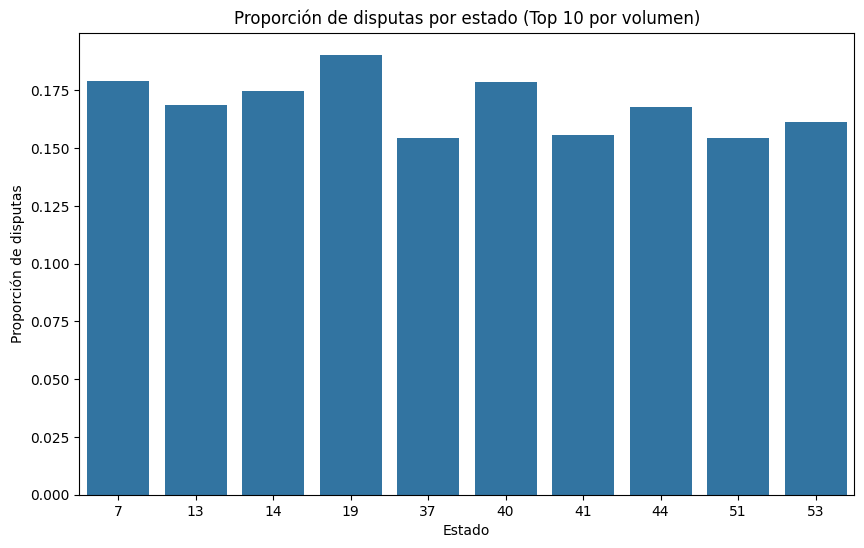

,total_quejas,disputas,pct_disputas
State,,,
7,3859,691,0.179062
13,2592,437,0.168596
51,2380,367,0.154202
40,1846,330,0.178765
14,1146,200,0.174520
37,1113,172,0.154537
44,1055,177,0.167773
19,1003,191,0.190429
41,939,146,0.155485


In [26]:
state_summary = (
    df.groupby("State")
    .agg(
        total_quejas=("Consumer_disputed", "count"),
        disputas=("Consumer_disputed", "sum")
    )
    .assign(pct_disputas=lambda d: d["disputas"] / d["total_quejas"])
    .sort_values("total_quejas", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=state_summary.reset_index(),
    x="State",
    y="pct_disputas"
)
plt.title("Proporción de disputas por estado (Top 10 por volumen)")
plt.ylabel("Proporción de disputas")
plt.xlabel("Estado")
plt.show()

state_summary


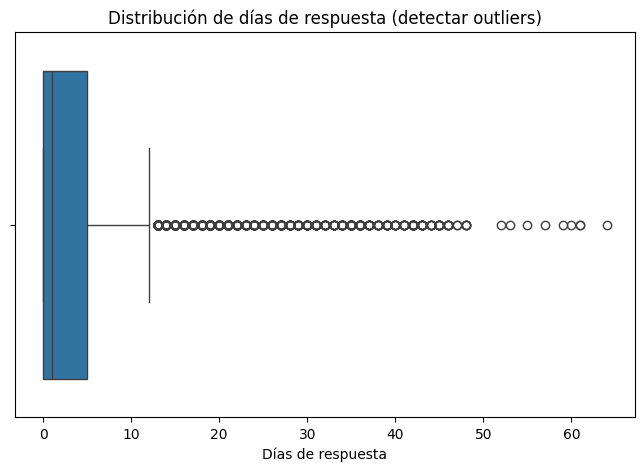

count    28156.000000
mean         2.959511
std          5.444020
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max         64.000000
Name: Days_to_response, dtype: float64

In [27]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df["Days_to_response"])
plt.title("Distribución de días de respuesta (detectar outliers)")
plt.xlabel("Días de respuesta")
plt.show()

df["Days_to_response"].describe()


La mayoría de las quejas se responden en pocos días (muy concentrado cerca de 0–5 días).

Existen outliers (puntos aislados) que llegan hasta más de 60 días.

El boxplot sugiere que el límite "normal" está alrededor de 12–15 días, y todo lo que está por encima se considera atípico.

👉 ¿Qué significa esto para tu proyecto?

Los outliers podrían distorsionar el modelo, ya que son pocos casos muy extremos.

Una opción es capar los valores (winsorizing), por ejemplo fijar un máximo de 30 días.

Otra opción es crear una variable categórica (bins: 0–1, 2–5, 6–10, >10 días), como ya probamos antes, que es más explicativa para negocio.

In [28]:
bins = [0, 1, 5, 10, 30, df['Days_to_response'].max()]
labels = ['0-1 días', '2-5 días', '6-10 días', '11-30 días', '30+ días']
df['Days_to_response_bin'] = pd.cut(df['Days_to_response'], bins=bins, labels=labels, include_lowest=True)

disputas_bin = df.groupby('Days_to_response_bin')['target_disputed'].agg(['count','sum','mean']).reset_index()
disputas_bin.rename(columns={'count':'total','sum':'disputas','mean':'pct_disputas'}, inplace=True)
disputas_bin


C:\Users\QiliDev\AppData\Local\Temp\ipykernel_6872\3615308027.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disputas_bin = df.groupby('Days_to_response_bin')['target_disputed'].agg(['count','sum','mean']).reset_index()


,Days_to_response_bin,total,disputas,pct_disputas
0,0-1 días,17339,3194,0.184209
1,2-5 días,5349,853,0.159469
2,6-10 días,4058,553,0.136274
3,11-30 días,1146,93,0.081152
4,30+ días,264,14,0.053030


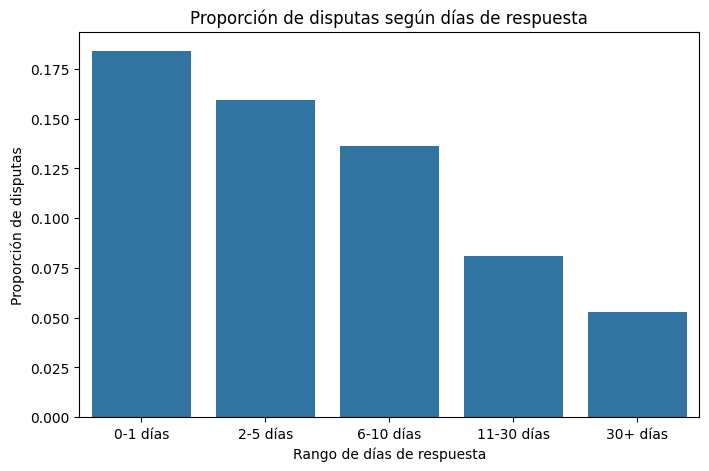

In [29]:
plt.figure(figsize=(8,5))
sns.barplot(x="Days_to_response_bin", y="pct_disputas", data=disputas_bin)
plt.title("Proporción de disputas según días de respuesta")
plt.ylabel("Proporción de disputas")
plt.xlabel("Rango de días de respuesta")
plt.show()


In [30]:
print("Shape:", df.shape)
na_cols = df.isnull().sum().sort_values(ascending=False)
display(na_cols[na_cols > 0])
print("NAs totales:", int(na_cols.sum()))
print("\nBalance de clases (target_disputed):")
print(df["target_disputed"].value_counts(normalize=True))
df.info()


Shape: (28156, 19)


bin_days    12987
dtype: int64

NAs totales: 12987

Balance de clases (target_disputed):
target_disputed
0    0.832824
1    0.167176
Name: proportion, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28156 entries, 0 to 28155
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Product               28156 non-null  int64         
 1   Sub_product           28156 non-null  object        
 2   Issue                 28156 non-null  object        
 3   Sub_issue             28156 non-null  object        
 4   State                 28156 non-null  int64         
 5   ZIP_code              28156 non-null  object        
 6   Date_received         28156 non-null  datetime64[ns]
 7   Date_sent_to_company  28156 non-null  datetime64[ns]
 8   Company               28156 non-null  int64         
 9   Company_response      28156 non-null  int64         
 10  Timely_response       28156 non-null  int64         
 11

In [32]:
if "bin_days" in df.columns:
    df.drop(columns=["bin_days"], inplace=True)


In [33]:
output_file = "../data/transformado/quejas_features.csv"
df.to_csv(output_file, index=False)

print(f"Archivo exportado a: {output_file}")
print(df.shape)
print(df.isna().sum().sum())
df.head()


Archivo exportado a: ../data/transformado/quejas_features.csv
(28156, 18)
0


,Product,Sub_product,Issue,Sub_issue,State,ZIP_code,Date_received,Date_sent_to_company,Company,Company_response,Timely_response,Consumer_disputed,target_disputed,Days_to_response,Issue_len,Sub_issue_words,Company_grouped,Days_to_response_bin
0,4,Desconocido,Communication tactics,Frequent or repeated calls,51,76119.0,2015-03-19,2015-03-19,1069,4,1,0,0,0,21,4,Otras,0-1 días
1,4,Medical,Cont'd attempts collect debt not owed,Debt is not mine,51,77479.0,2015-03-19,2015-03-19,50,1,1,0,0,0,37,4,Otras,0-1 días
2,6,FHA mortgage,"Application, originator, mortgage broker",Desconocido,24,2127.0,2015-03-19,2015-03-19,1118,1,1,1,1,0,40,1,1118,0-1 días
3,2,Desconocido,Other,Desconocido,7,92592.0,2015-03-19,2015-03-19,967,4,1,0,0,0,5,1,Otras,0-1 días
4,4,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,12,43068.0,2015-03-19,2015-03-19,1401,4,1,0,0,0,37,5,1401,0-1 días
